# Predicting the noise level of noisy FashionMNIST images

The goal is to predict the noise level of a noisy image so it can be passed into a pretrained diffusion model.
<br>
The original DDPM paper has 1000 timesteps, many follow that but we don't have to so lets break that convention.
When timesteps go from 0 to 1 it can simplify some things, maybe complicates others.
(In notebook 23 we will see an even simpler notation.)

We create a different kind of model, not a model that predicts the noise given the noised image and `t`.
Instead we define a model which predicts `t` given the noised image.
When we looked at some intermediate generated images, it seems that we can estimate roughly how much noise each image had.
When we call the model, why are we passing in the noised image and the amount of noise or the 't'.
The model could figure out how much noise there is.
Lets check the contention that the model could figure out how much noise there is.

## Imports

In [22]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import ImageEval

In [3]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Load dataset

Use 28x28 images, high batch size.

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256 #512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

Let's create a model that will figure out how much noise there is.
Defined a different `noisify(x0)` that grabs an alphabar_t `al_t` *randomly* between 0-1,  per item in the batch.
Now the independent variable is the noise image `xt`, and the dependent variable is `al_t`.
We define a model that can predict `al_t` given a noised image.

In [6]:
def noisify(x0):
    device = x0.device
    al_t = torch.rand((len(x0), 1, 1, 1), device=device)
    ε = torch.randn(x0.shape, device=device)
    xt = al_t.sqrt()*x0 + (1-al_t).sqrt()*ε
    return xt,al_t.squeeze().logit()

Re: the `logit()` above. 
`al_t` goes between 0-1, so *we don't have to do anything*, but we may consider putting a sigmoid at the end of the model.
The difference between 0.999 and 0.99 is significant, if we do `logit()` then we don't need the sigmoid at the end.
It will naturally cover the full range, be centered at zero with the normal range of numbers,
and it will treat equal ratios as equally important at both ends of the spectrum.
Testing confirmed the hypothesis that using `logit()` would be better, without the `logit()` the model didn't work well.
This is an example of thinking thru important details.
If we hadn't done the `logit()` we would have come away thinking we can't predict it's noise amount.

In [7]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [8]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [9]:
dl = dls.train
xt,amt = next(iter(dl))

In this example of a minibatch the numbers can be negative or positive, i.e., zero represents noise Alphabar of 0.5.
3.05 is not very noised, but -1.12 is pretty noisy.
Given this image we would predict 3.05.

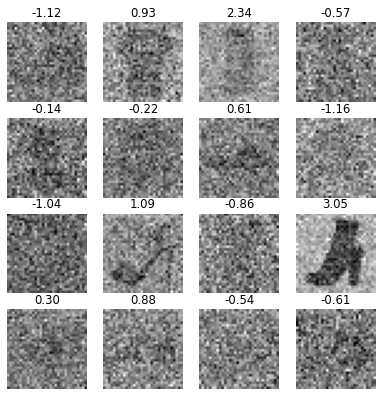

In [10]:
titles = [f'{o:.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

It is always useful to know a baseline, what counts as good, is it better than random or predicting the average?
If we always predicted a constant, e.g., 0., gives a loss of $\approx$ 3.567.

In [11]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): return torch.full((len(x),), 0.5)

In [12]:
metrics = MetricsCB()

In [13]:
lr = 1e-2
learn = TrainLearner(f(), dls, F.mse_loss, lr=lr, cbs=metrics)
learn.fit(1, train=False)

{'loss': '3.567', 'epoch': 0, 'train': 'eval'}


Another way to do it is just put MSE here, and then look at the MSE loss between 0.5 and a single minibatch 
If we're getting something that is about 3, then we haven't done any better than random.
The `f()` model doesn't have anything to learn, always returns the same thing, so we call `fit()` with `train=False` just to find the loss.
These are a couple of ways of quickly finding a loss for a baseline naive model.

In [14]:
F.mse_loss(amt,torch.full(amt.shape, 0.5))

tensor(3.7227)

Pytorch will warn if we try to use MSE and the inputs and targets have different shapes.
It will broadcast, and give a result that we would not expect, with a warning.
One way to avoid that is to use `.flatten` on each.
A flattened MSE is useful to avoid the warning and also avoid weird results.
We'll use that for our loss.

In [15]:
def flat_mse(x,y): return F.mse_loss(x.flatten(), y.flatten())

The model is the one that we always use, the difference is that  we just have one output now,
because this is a regression model, it's just trying to predict a single number.

In [16]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Dropout(0.2), nn.Linear(nfs[-1], 1, bias=False)]
    return nn.Sequential(*layers)

The learner now uses `flat_mse` as a loss, everything else is the same as usual.

In [17]:
opt_func = partial(optim.Adam, eps=1e-5)
epochs = 20
lr = 1e-2

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, flat_mse, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

We train it and see that the loss is better than 3, so we're learning something, and end up with a 0.075 MSE,
good considering the wide range of numbers we're trying to predict.

loss,epoch,train
0.320,0,train
0.215,0,eval
0.171,1,train
0.137,1,eval
0.137,2,train
0.351,2,eval
0.151,3,train
0.270,3,eval
0.155,4,train
0.153,4,eval


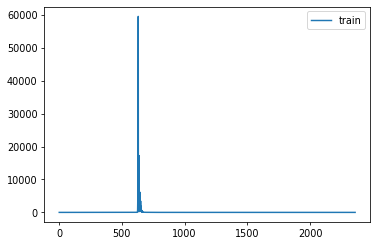

In [18]:
learn.fit(epochs)

We save that model as noise prediction on Sigma.

In [21]:
torch.save(learn.model, 'models/noisepred_sig.pkl')
# tmodel = learn.model
tmodel = torch.load('models/noisepred_sig.pkl').cuda()

We can take a look at how it's doing by grabbing one batch of noise images `xt`, putting it through our
`tmodel` (it's really an alphabar model but we called it a `tmodel`).
Then we can take a look to see what it's predicted for each one and we can compare it to the actual for each one.
Here it said I think it is about 0.91 and actually it is 0.91, similarly for others.
The hypothesis is correct, we can predict the thing that we were putting in manually as input.

In [ ]:
with torch.no_grad(): a = to_cpu(tmodel(xt.cuda()).squeeze())
titles = [f'{o.sigmoid():.2f}' for o in a[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

In [ ]:
titles = [f'{o.sigmoid():.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

## No-time model

2 reasons to check this: (1) it would be simpler if we weren't passing in the `t` each time.
and (2) it would open up a wider range of sampling.
It is limiting to precisely control the amount of noise we try to remove each time, 
and then remove exactly that amount of noise each time, feels limited.
So we want to try to remove this constraint.

In [23]:
from diffusers import UNet2DModel
from torch.utils.data import DataLoader,default_collate

In [24]:
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

Having built this model we don't need to pass-in `t`. Let's try it. 
Replicated the 22 cosine notebook, and made a couple of changes:
First is that `noisify()` doesn't return `t` anymore so there's no way to cheat, we don't know what `t` is.

In [25]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand((n,)).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape).to(x0)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return xt, ε

In [26]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

The UNet now doesn't have `t` so it's going to pass `(x,0)`  every time, it has no ability to learn from `t`.
It doesn't matter what we pass-in, we could have changed the UNet to remove the conditioning on `t`,
but for research this is just as good, for finding out...
*it's good to be lazy when doing research there's no point doing something a fancy way when you can do it a quick and easy way before you even know if it's going to work*.

In [27]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(x,0).sample

In [28]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [29]:
lr = 4e-3
epochs = 25
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

We train the model and check the loss, here is 0.034, previously it was 0.033 so interestingly it's a tiny bit worse,
but it is close.
We save that model.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/fashion_no-t.pkl')
model = learn.model = torch.load('models/fashion_no-t.pkl').cuda()

## Sampling

For sampling we've got the same DDIM step as usual, except now when calling the model we have no `t` to pass in, so we just pass-in this.
(we still know `t` because we are still using the usual sampling approach, but we are not passing it to the model.

In [ ]:
sz = (2048,1,32,32)

In [34]:
#sz = (512,1,32,32)
sz = (256,1,32,32)

In [37]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_51688/2668306936.py:1 in <module>     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_51688/2668306936.py'                 │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/serialization.py:771 in     │
│ load                                                                                             │
│                                                                                                  │
│    768 │   if 'encoding' not in pickle_load_args.keys():                                         │
│    769 │   │   pickle_load_args['encoding'] = 'utf-8'                                            │
│    770 │                                                                                         │
│ ❱  771 │   with _open_file_like(f, 'rb') as opened_file:                                         │
│    772 │   │   if _is_zipfile(opened_file):                                                      │
│    773 │   │   │   # The zipfile reader is going to advance the current file position.           │
│    774 │   │   │   # If we want to actually tail call to torch.jit.load, we need to              │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/serialization.py:270 in     │
│ _open_file_like                                                                                  │
│                                                                                                  │
│    267                                                                                           │
│    268 def _open_file_like(name_or_buffer, mode):                                                │
│    269 │   if _is_path(name_or_buffer):                                                          │
│ ❱  270 │   │   return _open_file(name_or_buffer, mode)                                           │
│    271 │   else:                                                                                 │
│    272 │   │   if 'w' in mode:                                                                   │
│    273 │   │   │   return _open_buffer_writer(name_or_buffer)                                    │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/serialization.py:251 in     │
│ __init__                                                                                         │
│                                                                                                  │
│    248                                                                                           │
│    249 class _open_file(_opener):                                                                │
│    250 │   def __init__(self, name, mode):                                                       │
│ ❱  251 │   │   super(_open_file, self).__init__(open(name, mode))                                │
│    252 │                                                                                         │
│    253 │   def __exit__(self, *args):                                                            │
│    254 │   │   self.file_like.close()                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 'mode

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    with torch.no_grad(): a = tmodel(x_t)[...,None,None].sigmoid()
    med = a.median()
    a = a.clamp(med/2,med*2)
    x_0_hat = ((x_t-(1-a).sqrt()*noise) / a.sqrt()).clamp(-2,2)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [30]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        abar_t = abar(t)
        noise = model(x_t)
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
#         print(abar_t,abar_t1,x_t.min(),x_t.max())
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [35]:
set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)

We sample and get garbage `FID>22`, some images are still noisy so we failed.
It is a little discouraging when you think something's going to work and it doesn't.
But, if we think something's going to work and it doesn't, lets understand why, and do it better if it ought to work.

In [ ]:
# classic ddim eta 1.0
ie.fid(s),ie.kid(s),s.shape

We got bad results, so lets try something different. 
Without passing in the `t` it doesn't know exactly how much noise to remove. 
It might remove a little bit more/less noise that we want.
We know from earlier testing that sometimes it's off, e.g., by 0.02.
If it is off consistently, sometimes it's gotta end up not removing all the noise.
So the change made was to the `ddim_step()`. 
Step One is the same. 
But now we use the (alphabar) `tmodel`, passing the noised images to get a predicted alphabar $\bar{\alpha}$ for each image.
<br>
We know from earlier that sometimes it did a good job, but sometimes it didn't.
JH discovered that sometimes it could be too low, so to ensure it wasn't "too crazy",
found the median `med` for a minibatch of all the predicted $\bar{\alpha}$ and clamped it 
`a = a.clamp(med/2, med*2)` to not be too far away from the median.
For `x_0_hat` rather than using `abar_t`  used the estimated alphabar_t `a` for each image clamped to be not too far away from the median.
This way it was updating it based on the amount of noise that actually seems to be left behind, 
rather than the assumed amount of noise that should be left behind, if we assume it has removed the correct amount.
All else is the same.

In [32]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    with torch.no_grad(): a = tmodel(x_t)[...,None,None].sigmoid()
    med = a.median()
    a = a.clamp(med/2,med*2)
    x_0_hat = ((x_t-(1-a).sqrt()*noise) / a.sqrt()).clamp(-2,2)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

This made all the difference, beautiful pieces of clothing, FID 3.88 vs 3.2, close enough.
We'd have to run it a few times, is probably a tiny bit worse but close.
While the `t` approaches have been developed since 2015, we expect that the no `t` approaches will eventually surpass the t-based approaches.
There is room to improve, if we plot the the FID or the KID for each sample during the reverse diffusion process it actually gets worse for a while.
That is a bad sign, no idea where that's happening, but it's a sign that if we could improve each step then we could get better than 3.8.

In [35]:
set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)

In [ ]:
show_images(s[:16], imsize=1.5)

In [ ]:
# model-t eta 1.0
ie.fid(s),ie.kid(s),s.shape

In [36]:
print("eta FID KID Shape\n")
for e in {0, 0.5, 1.0} :
    preds = sample(ddim_step, model, sz, steps=100, eta=0.5)
    s = (preds[-1]*2)
    print(e, ie.fid(s),ie.kid(s),s.shape)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_51688/950457040.py:4 in <module>      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_51688/950457040.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'ie' is not defined

In [ ]:
plt.plot([ie.kid((o*2).clamp(-1,1)) for o in preds]);

Jonno: Highlight the research process, it wasn't like this linear thing, it was multiple days of discussions.
Noticed in the paper they do clamping, maybe that can help.
There's a lot of back and forth, the code that was commented out,
prints xt.min xt.max alphabar, my average prediction is about what we'd expect.
But sometimes the max explodes... debugging and exploring and printing things out.
We are trying these out on some bigger models and seeing maybe it'll work.
Plan is spend the time train a proper model and see how well it does.